In [9]:
import rioxarray as rxr
import rasterio as rio
import geopandas as gpd
import xarray as xr
from geocube.api.core import make_geocube
import os
import asyncio
from sqlalchemy.ext.asyncio import create_async_engine
from sqlalchemy.engine import URL
from sqlalchemy.sql import text
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt


In [10]:
os.chdir("/app")

In [11]:
load_dotenv()
env_vars = os.environ

table_name = "luke_mvmi2015_segm_bmsum10kgha"

In [12]:
zone = gpd.read_file('data/test/testarea1.zip')

In [13]:
zone2 = gpd.read_file('data/tampere.geojson')

In [14]:
zone3 = gpd.read_file('data/vantaa_yk.shp')

In [15]:
zone.geometry.unary_union.area

144710.0383442599

In [16]:
zone.head()

,OBJECTID,fid_1,kaavamerki,kayttotark,pintaaala,id,Shape_Leng,Shape_Area,Luokka,hiili_maap,hiili_mets,hiili_maat,Hiili_Yht,H_yht_ha,geometry
0,1,1.0,AK,Kortteli tai korttelinosa,14336,2,711.836662,14335.674131,AK,131.5070,5.43386,4.41372,141.3550,98.6035,"POLYGON ((323383.089 6823223.647, 323394.528 6..."
1,2,2.0,VP,Virkistysalue,12916,4,1058.460420,12915.169520,V,86.8608,12.97950,0.00000,99.8403,77.3046,"POLYGON ((323049.878 6823131.088, 323053.532 6..."
2,3,3.0,YL,Kortteli tai korttelinosa,9149,5,472.400753,9148.459162,Y,66.3552,5.95482,1.91216,74.2222,81.1308,"POLYGON ((323595.598 6823137.188, 323597.152 6..."
3,4,4.0,AP-38,Kortteli tai korttelinosa,8096,6,447.714495,8095.779502,AP,76.1856,0.00000,0.00000,76.1856,94.1053,"POLYGON ((323131.370 6823139.759, 323130.049 6..."
4,5,5.0,LT-4,MuuLiikennealue,7524,7,1117.415576,7521.652753,L,57.1136,12.55860,1.39381,71.0660,94.4819,"POLYGON ((323049.878 6823131.088, 323046.324 6..."


In [17]:
zone["Luokka"].unique()

array(['AK', 'V', 'Y', 'AP', 'L', 'E'], dtype=object)

In [18]:
zone["factor"] = 1

<Axes: >

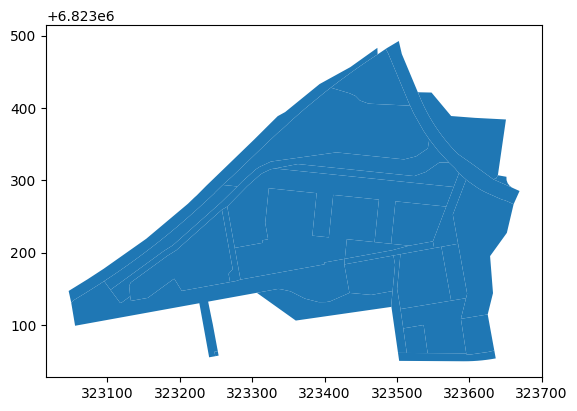

In [19]:
zone.plot()

In [20]:
zone.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

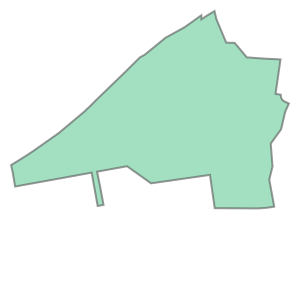

In [21]:
zone.geometry.unary_union

In [73]:
# unit is t C/ha
# convert to kg/grid cell, where cell size is 16x16

ha_to_grid = 16 * 16 / 10000
grid_to_ha = 1 / ha_to_grid

# Max AGB in finnish forest is 150 - 200 t C/ha in forest, which translates to 3500 - 4500 kg C/gridcell


In [22]:
wkt = zone.geometry.unary_union.wkt

In [23]:
url_object = URL.create(
    "postgresql+asyncpg",
    username=env_vars["PG_USER"],
    password=env_vars["PG_PASSWORD"],
    host="localhost",
    database=env_vars["PG_DB"],
    port=env_vars["PG_PORT"],
)


In [24]:
engine = create_async_engine(
    url_object,
    echo=True,
)


In [48]:


async def fetch_ground_carbon_for_region(wkt, crs):
    async with engine.connect() as conn:
        # select a Result, which will be delivered with buffered
        # results
        await conn.execute(text("SET postgis.gdal_enabled_drivers TO 'GTiff';"))

        statement = text(
            f"""
                SELECT
                ST_AsTIFF(ST_UNION(rast), 'LZW') as tiff
                FROM hiilikartta_maaperanhiili_tcha
                WHERE ST_Intersects(
                    rast, 
                        ST_SetSRID(
                            ST_GeomFromText(
                                :wkt
                            ),
                        3067
                    )
                );
            """
        )
        result = await conn.execute(statement, {"wkt": wkt, "crs": crs})

        return result.fetchall()[0][0]


# for AsyncEngine created in function scope, close and
# clean-up pooled connections


In [49]:
async def fetch_bio_carbon_for_region(wkt, crs):
    async with engine.connect() as conn:
        # select a Result, which will be delivered with buffered
        # results
        await conn.execute(text("SET postgis.gdal_enabled_drivers TO 'GTiff';"))

        statement = text(
            f"""
                SELECT
                ST_AsTIFF(ST_UNION(rast), 'LZW') as tiff
                FROM luke_mvmipuustonhiili_2021_tcha
                WHERE ST_Intersects(
                    rast, 
                        ST_SetSRID(
                            ST_GeomFromText(
                                :wkt
                            ),
                        3067
                    )
                );
            """
        )
        result = await conn.execute(statement, {"wkt": wkt, "crs": crs})

        return result.fetchall()[0][0]



await engine.dispose()

In [50]:
async def fetch_rasters_for_region(wkt, crs):
    async with engine.connect() as conn:
        await conn.execute(text("SET postgis.gdal_enabled_drivers TO 'GTiff';"))

        tiff_query = text(
            """
            SELECT ST_AsTIFF(ST_UNION(rast), 'LZW') as tiff
            FROM luke_mvmisegls_2021_id
                WHERE ST_Intersects(
                    rast, 
                    ST_Transform(
                        ST_SetSRID(
                            ST_GeomFromText(
                                :wkt
                            ), 
                            :crs
                        ), 
                        3067
                    )
                );
            """
        )

        variable_query = text(
            """
            SELECT *
            FROM luke_mvmisegls_2021_muuttujat
            JOIN luke_mvmisegls_2021_id 
                ON luke_mvmisegls_2021_muuttujat.kuvio_id = luke_mvmisegls_2021_id.rid
            WHERE ST_Intersects(
                luke_mvmisegls_2021_id.rast,
                ST_Transform(
                    ST_SetSRID(
                        ST_GeomFromText(:wkt),
                        :crs
                    ),
                    3067
                )
            );
            """
        )

        gather_results = await asyncio.gather(
            conn.execute(tiff_query, {"wkt": wkt, "crs": crs}),
            conn.execute(variable_query, {"wkt": wkt, "crs": crs}),
        )

        tiff_result = gather_results[0]
        variable_result = gather_results[1]

        tiff_data = tiff_result.fetchone()["tiff"]
        variable_rows = variable_result.fetchall()

        return tiff_data, variable_rows
    


In [51]:
async def fetch_variables_for_region(wkt, crs):
    async with engine.connect() as conn:
        await conn.execute(text("SET postgis.gdal_enabled_drivers TO 'GTiff';"))

        variable_query = text(
            """
            SELECT 
                luke_mvmisegls_2021_muuttujat.*,
                ST_AsTIFF(rast, 'LZW') as tiff
            FROM luke_mvmisegls_2021_muuttujat
            JOIN luke_mvmisegls_2021_id 
                ON luke_mvmisegls_2021_muuttujat.kuvio_id = luke_mvmisegls_2021_id.rid
            WHERE ST_Intersects(
                luke_mvmisegls_2021_id.rast,
                ST_Transform(
                    ST_SetSRID(
                        ST_GeomFromText(:wkt),
                        :crs
                    ),
                    3067
                )
            );
            """
        )

        result = await conn.execute(variable_query, {"wkt": wkt, "crs": crs})

        rows = result.fetchall()

        # Fetch column names
        column_names = list(result.keys())

        return rows, column_names


await engine.dispose()


In [29]:
test_poly='POLYGON((375344 6698336,375600 6698336,375600 6698080,375344 6698080,375344 6698336))'

In [30]:
rows, column_names = await fetch_variables_for_region(wkt=wkt, crs=3067)

datasets = []

for row in rows:
    rast = row[column_names.index("tiff")]
    
    with rio.MemoryFile(rast).open() as dataset:
        data_array = rxr.open_rasterio(dataset, masked=True)
    
    # 1. Convert data_array to a dataset
    ds = data_array.to_dataset(name='raster')
    
    # 2. Add other variables from the row to the dataset
    for col_name in column_names:
        if col_name != "tiff":
            # Add as a data variable (with the same value for all coordinates since it's a scalar)
            ds[col_name] = ('y', 'x'), [[row[column_names.index(col_name)]] * len(ds['x'])] * len(ds['y'])
    
    # 3. Append the dataset to datasets
    datasets.append(ds)

variables_ds = datasets[0]

for ds in datasets[1:]:
    variables_ds = xr.combine_by_coords([variables_ds, ds], combine_attrs="override")

variables_ds = variables_ds.squeeze(dim="band", drop=True)


2023-09-10 10:37:47,411 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-09-10 10:37:47,413 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-10 10:37:47,508 INFO sqlalchemy.engine.Engine select current_schema()
2023-09-10 10:37:47,510 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-10 10:37:47,603 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-09-10 10:37:47,605 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-09-10 10:37:47,688 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-09-10 10:37:47,689 INFO sqlalchemy.engine.Engine SET postgis.gdal_enabled_drivers TO 'GTiff';
2023-09-10 10:37:47,691 INFO sqlalchemy.engine.Engine [generated in 0.00301s] ()


2023-09-10 10:37:47,761 INFO sqlalchemy.engine.Engine 
            SELECT 
                luke_mvmisegls_2021_muuttujat.*,
                ST_AsTIFF(rast, 'LZW') as tiff
            FROM luke_mvmisegls_2021_muuttujat
            JOIN luke_mvmisegls_2021_id 
                ON luke_mvmisegls_2021_muuttujat.kuvio_id = luke_mvmisegls_2021_id.rid
            WHERE ST_Intersects(
                luke_mvmisegls_2021_id.rast,
                ST_Transform(
                    ST_SetSRID(
                        ST_GeomFromText(%s),
                        %s
                    ),
                    3067
                )
            );
            
2023-09-10 10:37:47,762 INFO sqlalchemy.engine.Engine [generated in 0.00105s] ('POLYGON ((323226.9685000004 6823130.252999999, 323055.2400000002 6823099.099399999, 323049.87770000007 6823131.087900002, 323046.3241999997 6823147.1 ... (2023 characters truncated) ... .045000002, 323253.6266999999 6823057.851599999, 323249.0022999998 6823057.0126999

In [55]:
async def get_bio_carbon(wkt: str, crs: str) -> xr.DataArray:
    rast = await fetch_bio_carbon_for_region(wkt, crs)

    with rio.MemoryFile(rast).open() as dataset:
        bio_carbon_da = rxr.open_rasterio(dataset, masked=True)
        # no data is 32766, non-forest is 32767
        bio_carbon_da.where(bio_carbon_da < 32766)

        return bio_carbon_da

In [56]:
async def get_ground_carbon(wkt: str, crs: str) -> xr.DataArray:
    rast = await fetch_ground_carbon_for_region(wkt, crs)

    with rio.MemoryFile(rast).open() as dataset:
        ground_carbon_da = rxr.open_rasterio(dataset, masked=True)
        # no data is 32766, non-forest is 32767
        ground_carbon_da.where(ground_carbon_da < 32766)

        return ground_carbon_da


In [57]:
ground_carbon = await get_ground_carbon(wkt=wkt, crs=3067)

2023-09-10 10:44:17,741 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-09-10 10:44:17,743 INFO sqlalchemy.engine.Engine SET postgis.gdal_enabled_drivers TO 'GTiff';
2023-09-10 10:44:17,744 INFO sqlalchemy.engine.Engine [cached since 390.1s ago] ()
2023-09-10 10:44:17,836 INFO sqlalchemy.engine.Engine 
                SELECT
                ST_AsTIFF(ST_UNION(rast), 'LZW') as tiff
                FROM hiilikartta_maaperanhiili_tcha
                WHERE ST_Intersects(
                    rast, 
                        ST_SetSRID(
                            ST_GeomFromText(
                                %s
                            ),
                        3067
                    )
                );
            
2023-09-10 10:44:17,837 INFO sqlalchemy.engine.Engine [cached since 387.7s ago] ('POLYGON ((323226.9685000004 6823130.252999999, 323055.2400000002 6823099.099399999, 323049.87770000007 6823131.087900002, 323046.3241999997 6823147.1 ... (2023 characters truncated) ..

/tmp/ipykernel_8713/19717777.py:1: RuntimeWarning: coroutine 'fetch_ground_carbon_for_region' was never awaited
  ground_carbon = await get_ground_carbon(wkt=wkt, crs=3067)


In [58]:
ground_carbon = await get_bio_carbon(wkt=wkt, crs=3067)

2023-09-10 10:44:19,291 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-09-10 10:44:19,293 INFO sqlalchemy.engine.Engine SET postgis.gdal_enabled_drivers TO 'GTiff';
2023-09-10 10:44:19,296 INFO sqlalchemy.engine.Engine [cached since 391.6s ago] ()
2023-09-10 10:44:19,369 INFO sqlalchemy.engine.Engine 
                SELECT
                ST_AsTIFF(ST_UNION(rast), 'LZW') as tiff
                FROM luke_mvmipuustonhiili_2021_tcha
                WHERE ST_Intersects(
                    rast, 
                        ST_SetSRID(
                            ST_GeomFromText(
                                %s
                            ),
                        3067
                    )
                );
            
2023-09-10 10:44:19,370 INFO sqlalchemy.engine.Engine [cached since 388.5s ago] ('POLYGON ((323226.9685000004 6823130.252999999, 323055.2400000002 6823099.099399999, 323049.87770000007 6823131.087900002, 323046.3241999997 6823147.1 ... (2023 characters truncated) .

In [33]:
variables_ds

<xarray.Dataset>
Dimensions:        (x: 1000, y: 1000)
Coordinates:
  * x              (x) float64 3.169e+05 3.169e+05 ... 3.328e+05 3.328e+05
  * y              (y) float64 6.836e+06 6.836e+06 ... 6.82e+06 6.82e+06
    spatial_ref    int64 0
    band           int64 1
Data variables: (12/28)
    raster         (y, x) float64 ...
    kuvio_id       (y, x) int64 289 289 289 289 289 289 ... 289 289 289 289 289
    n              (y, x) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    paatyyppi      (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    maalk          (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    fra            (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...             ...
    muulpvol       (y, x) float64 2.75 2.75 2.75 2.75 ... 2.75 2.75 2.75 2.75
    mlpk           (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    mlpt           (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bm_10kgha      (y, x) float64 6.754e+03 6.754e+03 ... 6.754e+03 6.754e+03
    ground_carbon  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    bio_carbon     (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [63]:
def combine_data(
    variables_ds: xr.Dataset,
    bio_carbon_da: xr.DataArray,
    ground_carbon_da: xr.DataArray,
):
    variables_ds["bio_carbon"] = bio_carbon_da.sel(band=1)
    variables_ds["ground_carbon"] = ground_carbon_da.sel(band=1)

    return variables_ds

In [64]:
combine_data(variables_ds, bio_carbon_da, ground_carbon_da)

<xarray.Dataset>
Dimensions:        (x: 1000, y: 1000)
Coordinates:
  * x              (x) float64 3.169e+05 3.169e+05 ... 3.328e+05 3.328e+05
  * y              (y) float64 6.836e+06 6.836e+06 ... 6.82e+06 6.82e+06
    spatial_ref    int64 0
    band           int64 1
Data variables: (12/28)
    raster         (y, x) float64 ...
    kuvio_id       (y, x) int64 289 289 289 289 289 289 ... 289 289 289 289 289
    n              (y, x) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    paatyyppi      (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    maalk          (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    fra            (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...             ...
    muulpvol       (y, x) float64 2.75 2.75 2.75 2.75 ... 2.75 2.75 2.75 2.75
    mlpk           (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    mlpt           (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bm_10kgha      (y, x) float64 6.754e+03 6.754e+03 ... 6.754e+03 6.754e+03
    ground_carbon  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    bio_carbon     (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [65]:
zone_raster = make_geocube(zone, resolution=(-16, 16), measurements=["factor"], output_crs="EPSG:3067")


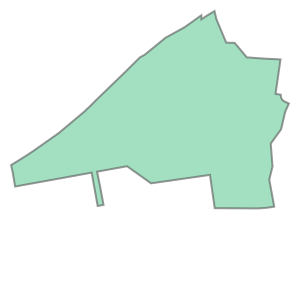

In [66]:
zone.geometry.unary_union

In [70]:
def get_area_das(zone_df, ds):
    bounds = zone_df.geometry.unary_union.bounds
    minx, miny, maxx, maxy = bounds

    # Define the resolution you want
    res = 1  # Adjust as needed

    # Compute dimensions based on bounding box and resolution
    height = int((maxy - miny) / res)
    width = int((maxx - minx) / res)

    # Define the transform
    transform = rio.transform.from_origin(minx, maxy, res, res)

    crs_code = zone_df.crs.to_string()
    data_arrays = []

    for index, row in zone_df.iterrows():
        # Create a binary mask where the polygon is
        mask = rio.features.geometry_mask(
            [row["geometry"]],
            transform=transform,
            invert=True,
            out_shape=(height, width),
        )

        # Convert mask to xarray DataArray
        da = xr.DataArray(
            np.where(
                mask, row["factor"], np.nan
            ),  # Assign the "factor" value where the mask is True, otherwise NaN
            dims=("y", "x"),
            coords={
                "x": np.linspace(minx, maxx - res, width),
                "y": np.linspace(maxy, miny - res, height),
            },
            name=f"polygon_{row['id']}",
        )
        da.rio.set_crs(crs_code, inplace=True)
        da.attrs["df_index"] = index
        da = da.interp(y=variables_ds.y, x=variables_ds.x)
        data_arrays.append(da)

    return data_arrays


In [77]:
area_das = get_area_das(zone, variables_ds)

zone_cp = zone.copy()

columns = [
    "bio_carbon_sum",
    "ground_carbon_sum",
    "bio_carbon_per_area",
    "ground_carbon_per_area",
]
years = ["now", "2035", "2045", "2055"]

all_columns = []

for col in columns:
    for year in years:
        for suffix in ["nochange", "planned"]:
            all_columns.append(f"{col}_{suffix}_{year}")

for col in all_columns:
    zone_cp[col] = None

zone_cp["area"] = zone_cp["geometry"].area

for da in area_das:
    bio_carbon_sum = (da * variables_ds["bio_carbon"]).sum(skipna=True).item()
    ground_carbon_sum = (da * variables_ds["ground_carbon"]).sum(skipna=True).item()
    index = da.attrs[
        "df_index"
    ]  # Get the appropriate index/row from the DataArray attribute
    zone_cp.at[index, "bio_carbon_sum_nochange_now"] = bio_carbon_sum
    zone_cp.at[index, "ground_carbon_sum_nochange_now"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_nochange_now"] = bio_carbon_sum * ha_to_grid
    zone_cp.at[index, "ground_carbon_per_area_nochange_now"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_nochange_2035"] = bio_carbon_sum * 1.1
    zone_cp.at[index, "ground_carbon_sum_nochange_2035"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_nochange_2035"] = (
        bio_carbon_sum * 1.1 * ha_to_grid
    )
    zone_cp.at[index, "ground_carbon_per_area_nochange_2035"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_nochange_2045"] = bio_carbon_sum * 1.2
    zone_cp.at[index, "ground_carbon_sum_nochange_2045"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_nochange_2045"] = (
        bio_carbon_sum * 1.2 * ha_to_grid
    )
    zone_cp.at[index, "ground_carbon_per_area_nochange_2045"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_nochange_2055"] = bio_carbon_sum * 1.3
    zone_cp.at[index, "ground_carbon_sum_nochange_2055"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_nochange_2055"] = (
        bio_carbon_sum * 1.3 * ha_to_grid
    )
    zone_cp.at[index, "ground_carbon_per_area_nochange_2055"] = (
        ground_carbon_sum * ha_to_grid
    )

    # planned values
    zone_cp.at[index, "bio_carbon_sum_planned_now"] = 0
    zone_cp.at[index, "ground_carbon_sum_planned_now"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_planned_now"] = 0
    zone_cp.at[index, "ground_carbon_per_area_planned_now"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_planned_2035"] = 0
    zone_cp.at[index, "ground_carbon_sum_planned_2035"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_planned_2035"] = 0
    zone_cp.at[index, "ground_carbon_per_area_planned_2035"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_planned_2045"] = 0
    zone_cp.at[index, "ground_carbon_sum_planned_2045"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_planned_2045"] = 0
    zone_cp.at[index, "ground_carbon_per_area_planned_2045"] = (
        ground_carbon_sum * ha_to_grid
    )

    zone_cp.at[index, "bio_carbon_sum_planned_2055"] = 0
    zone_cp.at[index, "ground_carbon_sum_planned_2055"] = ground_carbon_sum
    zone_cp.at[index, "bio_carbon_per_area_planned_2055"] = 0
    zone_cp.at[index, "ground_carbon_per_area_planned_2055"] = (
        ground_carbon_sum * ha_to_grid
    )

sum_cols = [col for col in all_columns if "_sum" in col]
sum_result = zone_cp[sum_cols].sum()

# 2. For all "per_area" columns
per_area_cols = [col for col in all_columns if "_per_area" in col]
weighted_averages = {}

total_area = zone_cp["area"].sum()
for col in per_area_cols:
    weighted_sum = (zone_cp[col] * zone_cp["area"]).sum()
    weighted_averages[col] = weighted_sum / total_area

# Merge the results
agg_results = {**sum_result.to_dict(), **weighted_averages}
agg_results["geometry"] = zone_cp.geometry.unary_union
summed_gdf = gpd.GeoDataFrame([agg_results], geometry="geometry")
summed_gdf["area"] = summed_gdf["geometry"].area


In [78]:
zone_cp.head()

,OBJECTID,fid_1,kaavamerki,kayttotark,pintaaala,id,Shape_Leng,Shape_Area,Luokka,hiili_maap,...,bio_carbon_per_area_planned_2055,ground_carbon_per_area_nochange_now,ground_carbon_per_area_planned_now,ground_carbon_per_area_nochange_2035,ground_carbon_per_area_planned_2035,ground_carbon_per_area_nochange_2045,ground_carbon_per_area_planned_2045,ground_carbon_per_area_nochange_2055,ground_carbon_per_area_planned_2055,area
0,1,1.0,AK,Kortteli tai korttelinosa,14336,2,711.836662,14335.674131,AK,131.5070,...,0,126.592,None,None,126.592,None,126.592,None,126.592,14335.674131
1,2,2.0,VP,Virkistysalue,12916,4,1058.460420,12915.169520,V,86.8608,...,0,87.8592,None,None,87.8592,None,87.8592,None,87.8592,12915.169520
2,3,3.0,YL,Kortteli tai korttelinosa,9149,5,472.400753,9148.459162,Y,66.3552,...,0,66.3552,None,None,66.3552,None,66.3552,None,66.3552,9148.459162
3,4,4.0,AP-38,Kortteli tai korttelinosa,8096,6,447.714495,8095.779502,AP,76.1856,...,0,78.6432,None,None,78.6432,None,78.6432,None,78.6432,8095.779502
4,5,5.0,LT-4,MuuLiikennealue,7524,7,1117.415576,7521.652753,L,57.1136,...,0,53.1968,None,None,53.1968,None,53.1968,None,53.1968,7521.652753


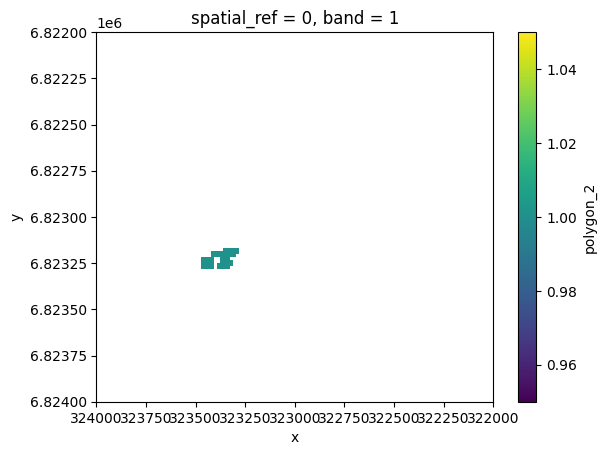

In [631]:
adjusted_da.plot()
plt.ylim(6.824 * 1e6, 6.822 * 1e6)  # The order is reversed since y-coordinates are typically plotted from top to bottom
plt.xlim(324000, 322000)
plt.show()

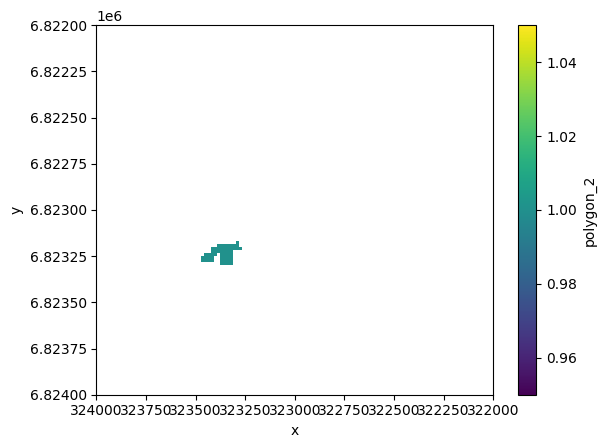

In [632]:
das[0].plot()
plt.ylim(6.824 * 1e6, 6.822 * 1e6)  # The order is reversed since y-coordinates are typically plotted from top to bottom
plt.xlim(324000, 322000)
plt.show()

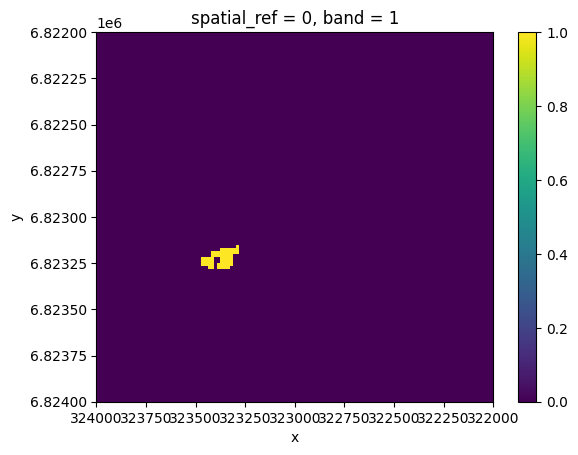

In [643]:
dataarray.plot()
plt.ylim(6.824 * 1e6, 6.822 * 1e6)  # The order is reversed since y-coordinates are typically plotted from top to bottom
plt.xlim(324000, 322000)
plt.show()

In [637]:
print(das[0].sum())
print(adjusted_da.sum())

<xarray.DataArray 'polygon_2' ()>
array(53.)
<xarray.DataArray 'polygon_2' ()>
array(54.)
Coordinates:
    spatial_ref  int64 0
    band         int64 1


In [540]:
adjusted_bio = variables_ds["bio_carbon"].interp(y=data_arrays[0].y, x=data_arrays[0].x)

<xarray.DataArray 'bio_carbon' ()>
array(2.48278864e+08)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [538]:
original_sum = variables_ds["bio_carbon"].sum().values
adjusted_bio = variables_ds["bio_carbon"].interp(y=data_arrays[0].y, x=data_arrays[0].x)
adjusted_sum = adjusted_bio.sum().values

scaling_factor = original_sum / adjusted_sum
adjusted_bio_scaled = adjusted_bio * scaling_factor

(data_arrays[0] * adjusted_bio_scaled).sum(skipna=True)

<xarray.DataArray ()>
array(7535303.64626629)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [536]:
variables_ds["bio_carbon"].sum()

<xarray.DataArray 'bio_carbon' ()>
array(2.4827886e+08, dtype=float32)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [528]:
adjusted_bio_scaled.sum()

<xarray.DataArray 'bio_carbon' ()>
array(9698388.00000005)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [645]:
(dataarray * variables_ds["bio_carbon"]).sum(skipna=True)

<xarray.DataArray ()>
array(245.53, dtype=float32)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [646]:
(data_arrays[0] * variables_ds["bio_carbon"]).sum(skipna=True)

<xarray.DataArray ()>
array(0.)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

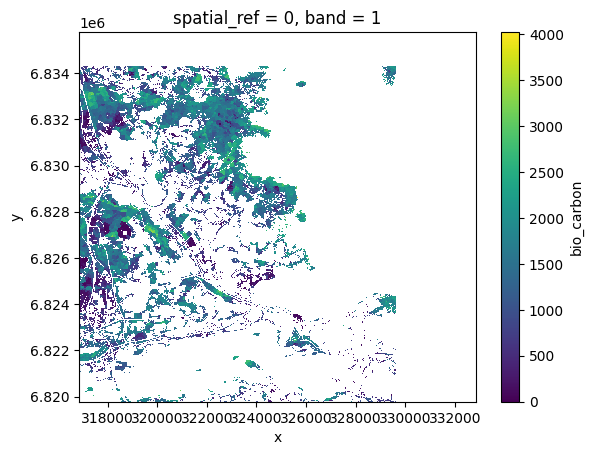

In [417]:
ass = variables_ds["bio_carbon"]  * ha_to_grid

ass.plot()

In [535]:
variables_ds["ground_carbon"] = variables_ds["ground_carbon"]  * ha_to_grid
variables_ds["bio_carbon"] = variables_ds["bio_carbon"]  * ha_to_grid

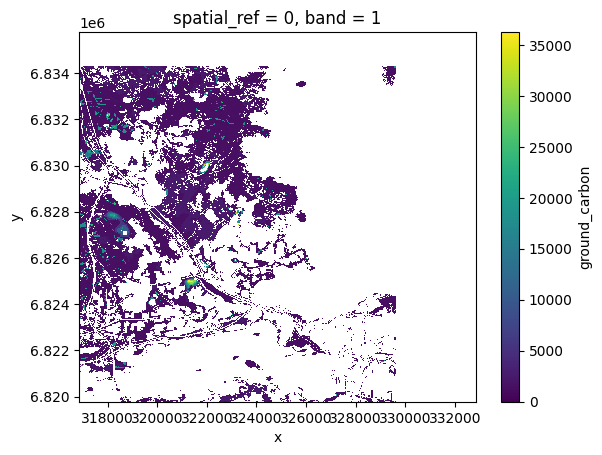

In [396]:
variables_ds["ground_carbon"].plot()

In [438]:
zone_raster

<xarray.Dataset>
Dimensions:      (y: 29, x: 40)
Coordinates:
  * y            (y) float64 6.823e+06 6.823e+06 ... 6.823e+06 6.823e+06
  * x            (x) float64 3.23e+05 3.231e+05 ... 3.237e+05 3.237e+05
    spatial_ref  int64 0
Data variables:
    factor       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

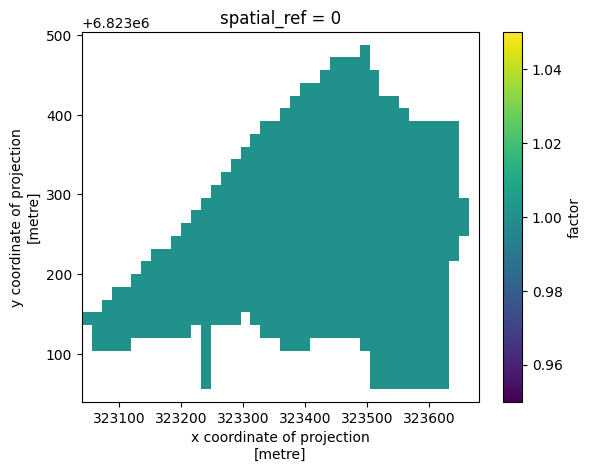

In [385]:
zone_raster["factor"].plot()

In [424]:
carbon_arr = zone_raster["factor"] * variables_ds["ground_carbon"]

In [425]:
carbon_arr.sum(skipna=True)

<xarray.DataArray ()>
array(43677.)
Coordinates:
    spatial_ref  int64 0
    band         int64 1

In [31]:
carbon_arr.sum(skipna=True)

<xarray.DataArray ()>
array(57914465.51039997)
Coordinates:
    spatial_ref  int64 0